# Model Iteration 2 -- Earthquake Dataset

Keenan and James

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import re

%matplotlib inline

quakes = pd.read_csv("./downloaded/data.csv")

print quakes.head()

                       time  latitude  longitude  depth  mag magType  nst  \
0  1901-08-09T18:33:00.000Z        40        144      0  7.5      mw  NaN   
1  1901-08-09T13:01:00.000Z       -22        170      0  7.9      mw  NaN   
2  1902-04-19T02:23:00.000Z        14        -91      0  7.5      mw  NaN   
3  1902-09-23T20:18:00.000Z        16        -93      0  7.8      mw  NaN   
4  1902-09-22T01:46:00.000Z        18        146      0  7.5      mw  NaN   

   gap  dmin  rms    ...                      updated  \
0  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
1  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
2  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
3  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
4  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   

                                       place        type horizontalError  \
0        off the east coast of Honshu, Japan  earthquake             NaN   
1           southeast of the Loyalty Islan

We wrote some helper functions that will help us test the progress we have made in the models quickly.

In [7]:
from sklearn.cross_validation import train_test_split

def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

### Features

In [90]:
def magclassify(mag):
    if mag < 4:
        return 0
    elif mag < 5:
        return 1
    elif mag < 6:
        return 2
    elif mag < 7:
        return 3
    elif mag < 8:
        return 4
    elif mag >= 8:
        return 5
# "minor" "light" "moderate" "strong" "major" "great"   

def classifyMagType(magType):
    duration = ["Md", "md"]
    local = ["ml"]
    shortPS = ["mb_lg", "lg", "mblg"]
    shortPeriodWave = ["mb"]
    twenty = ["ms", "ms_20"]
    moment = ["mi", "mwp"]
    energy = ["me"]
    
    mw = ["mw", "mwb", "mwc","mwr","mww"]
    magType = str(magType).lower()
    if magType in duration:
        return 0
    elif magType in local:
        return 1
    elif magType in shortPS:
        return 2
    elif magType in shortPeriodWave:
        return 3
    elif magType in twenty:
        return 4
    elif magType in moment:
        return 5
    elif magType in energy:
        return 6
    elif magType in mw:
        return 7
    else:
        return 8    
    
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [91]:
def add_features():
    quakes["magClassified"] = quakes["mag"].apply(magclassify)
    quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())
    quakes["magTypeClassified"] =  quakes["magType"].apply(classifyMagType)
    quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
    quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
    quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])

In [92]:
add_features()

In [12]:
logistic = LogisticRegression()
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)
predictors = ["latitude", "longitude", "depth"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.78255755726613174

In [13]:
predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.85619126363964548

In [57]:
from geopy.geocoders import Nominatim

geolocator = Nominatim()
# location = geolocator.reverse("-6.0326, 103.7117")
location = geolocator.reverse("42.2926850,-71.2644100")
# location = geolocator.reverse("33.7787,-38.0533")
print location.address

Milas Hall, Olin Way, Needham, Norfolk County, Massachusetts, 02492-1200, United States of America


In [121]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
encoding = encoder.fit_transform(quakes.country)
quakes["countryEncoding"] =  pd.Series(encoding, index=quakes.index)

In [45]:
def latLongToAddress(lat, longi):
    array = []
    for i in range(len(lat)):
        array.append(str(lat[i]) + ", " + str(longi[i]))
    return array

In [143]:
quakes.magClassified.value_counts()

0    309610
1    298257
2     68246
3      9522
4      1241
5        92
Name: magClassified, dtype: int64

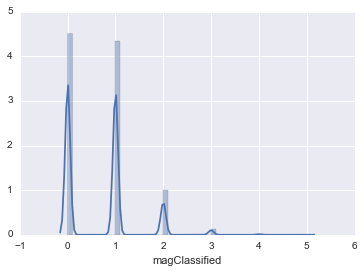

In [144]:
sns.distplot(quakes.magClassified)

In [136]:
quakes["combined"] = array
quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])
# quakes["country"] = quakes.country.apply(lambda x: str(x).split(", ")[-1])
# quakes.loc[quakes["country"] == "male", "Sex"] = 0
# quakes.loc[quakes.country.value_counts() == 1, "country"] = "else"
print type(quakes.country.value_counts())
print quakes.country.value_counts()

<class 'pandas.core.series.Series'>
Indonesia                                  41514
Alaska                                     37083
CA                                         34014
Chile                                      33567
Japan                                      24219
California                                 21970
Papua New Guinea                           21812
Greece                                     19337
Mexico                                     17996
Philippines                                12731
Japan region                               11730
western Turkey                             11572
Fiji region                                10139
Kuril Islands                               8995
Argentina                                   8972
Vanuatu                                     8397
MX                                          8064
Russia                                      7881
Central Alaska                              7787
Tonga                            

In [12]:
quakes["fault"] = quakes.place.apply(lambda x: True if "Ridge" in str(x).split() else False)
quakes.fault.value_counts()


False    674520
True      12448
Name: fault, dtype: int64

In [140]:
predictors = ["latitude", "longitude", "depth", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.80892850904263369

In [189]:
count = 0
for i in alg.predict(X_test):
    if i >3:
        count+=1
print count

17


In [174]:
predictors = ["latitude", "longitude", "year", "month", "hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
logistic.fit(X_train, y_train)
logistic.score(X_test, y_test)

0.6869402941621735

In [183]:
quakes.groupby("magClassified").count()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,combined,country,magTypeClassified,year,month,hour,test,t,countryEncoding,Sex
magClassified,,,,,,,,,,,,,,,,,,,,,
0,309610,309610,309610,309610,309610,309489,201511,187192,42272,172925,...,309610,309610,309610,309610,309610,309610,309610,309610,309610,0
1,298257,298257,298257,298257,298257,298248,142460,152900,34884,253576,...,298257,298257,298257,298257,298257,298257,298257,298257,298257,0
2,68246,68246,68246,68246,68246,68244,22612,22735,3752,51789,...,68246,68246,68246,68246,68246,68246,68246,68246,68246,0
3,9522,9522,9522,9522,9522,9522,1969,1931,346,4736,...,9522,9522,9522,9522,9522,9522,9522,9522,9522,0
4,1241,1241,1241,1241,1241,1241,194,193,37,474,...,1241,1241,1241,1241,1241,1241,1241,1241,1241,0
5,92,92,92,92,92,92,19,19,2,31,...,92,92,92,92,92,92,92,92,92,0


In [213]:
for i in range(100):
    a=  logistic.predict_proba([42.2926850+i,-71.2644100-i, 2016, 3, 12])
    print weighted(a[0])
    
def weighted(a):
    s= 0
    for i in range(6):
        s += i *a[i]
    return s/6

0.0559032820271
0.0547014330552
0.053525691874
0.0523755947211
0.0512506671008
0.0501504261831
0.0490743830193
0.0480220445781
0.0469929156077
0.0459865003283
0.0450023039641
0.0440398341189
0.0430986020065
0.0421781235408
0.0412779202959
0.0403975203433
0.0395364589757
0.0386942793236
0.0378705328749
0.037064779904
0.0362765898176
0.0355055414264
0.034751223147
0.0340132331425
0.0332911794071
0.0325846798015
0.0318933620427
0.0312168636561
0.0305548318917
0.0299069236113
0.0292728051493
0.0286521521513
0.0280446493942
0.0274499905905
0.0268678781795
0.0262980231095
0.0257401446106
0.0251939699631
0.0246592342611
0.0241356801748
0.023623057711
0.0231211239754
0.0226296429355
0.022148385187
0.0216771277233
0.0212156537097
0.0207637522618
0.0203212182301
0.0198878519896
0.0194634592364
0.0190478507897
0.0186408424011
0.0182422545705
0.017851912368
0.0174696452637
0.0170952869633
0.0167286752511
0.0163696518389
0.0160180622222
0.0156737555421
0.0153365844535
0.015006405
0.0146830764938
0.

/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

In [25]:
a = np.array(alg.predict_proba(X_test))

[[  4.31630865e-02   8.74487986e-01   8.22444342e-02   1.04493208e-04
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.40339518e-01   7.05882560e-01   4.78955685e-02
    5.88235294e-03   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  9.88000000e-01   1.20000000e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.05677656e-01   8.74725275e-01   1.95970696e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.46801583e-02   8.79159866e-01   7.61599755e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
(343484, 6)
[1 2 0 ..., 0 1 1]


In [23]:
# quakes["fault"] = quakes.place.apply(lambda x: True if "Ridge" in str(x).split() else False)
quakes["distance"] = quakes.place.apply(lambda x: [int(s) for s in re.findall(r'\d+', str(x))])
quakes["distance"]

0            []
1            []
2            []
3            []
4            []
5            []
6            []
7            []
8            []
9            []
10           []
11           []
12           []
13           []
14           []
15           []
16           []
17           []
18           []
19           []
20           []
21           []
22           []
23           []
24           []
25           []
26           []
27           []
28           []
29           []
          ...  
686938     [12]
686939     [53]
686940     [22]
686941     [39]
686942    [101]
686943     [55]
686944     [22]
686945     [35]
686946      [6]
686947      [6]
686948       []
686949     [54]
686950     [62]
686951      [6]
686952     [69]
686953       []
686954     [21]
686955    [153]
686956    [105]
686957     [30]
686958     [92]
686959     [67]
686960      [1]
686961    [147]
686962     [29]
686963    [127]
686964    [122]
686965    [102]
686966    [122]
686967     [85]
Name: distance, dtype: o

In [25]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,10)

  # scipy.cluster.vq.kmeans
KM = [kmeans(X_train,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X_train, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X_train.shape[0] for d in dist]  

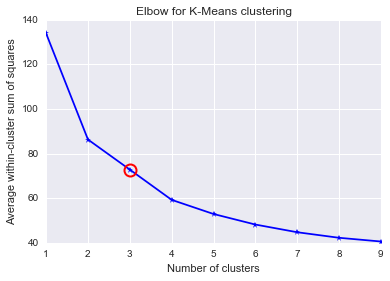

In [26]:
kIdx = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [33]:
from sklearn.cluster import KMeans
km = KMeans(3, init='k-means++') # initialize
km.fit(X_train)
c = km.predict(X_train) # classify into three clusters

In [31]:
print c

[1 1 1 ..., 0 1 0]
